This notebook aims to analyze the training results of JAX-CanVeg.

In [14]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

# Locations of files and folders

In [3]:
sites = ["US-Bi1", "US-Hn1", "US-Me2", "US-Whs"]
canopy_layers = ["1L", "ML"]
model_types = ["PB", "Hybrid"]
le_weight = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
canveg_combinations = list(
    itertools.product(sites, canopy_layers, model_types, le_weight)
)
dnn_combinations = list(itertools.product(sites, le_weight))

# Load the training results

## Modeling performances

In [48]:
df_metrics = pd.DataFrame(
    columns=[
        "site",
        "model",
        "layer",
        "weight",
        "varn",
        "train_or_test",
        "rse",
        "mare",
        "rmse",
        "mse",
        "r2",
        "kge",
        "nse",
        "mkge",
        "cc",
        "alpha",
        "beta",
    ]
)
i = 0

# JAX-CanVeg
for site, cl, mt, mow in tqdm(canveg_combinations):
    dir_model = Path(site) / f"{mt}-{cl}-{mow}"
    if not dir_model.is_dir():
        continue
    f_metrics = dir_model / "metrics.csv"
    df_metrics_model = pd.read_csv(f_metrics, index_col=0)
    for index, row in df_metrics_model.iterrows():
        index = index.split("-")
        varn, train_or_test = index[0], index[1]
        df_metrics.loc[i] = [
            site,
            mt,
            cl,
            mow,
            varn,
            train_or_test,
            row["rse"],
            row["mare"],
            row["rmse"],
            row["mse"],
            row["r2"],
            row["kge"],
            row["nse"],
            row["mkge"],
            row["cc"],
            row["alpha"],
            row["beta"],
        ]
        i += 1

# DNN
for site, mow in tqdm(dnn_combinations):
    dir_model = Path(site) / f"DNN_LE-GPP-{mow}"
    if not dir_model.is_dir():
        continue
    f_metrics = dir_model / "metrics.csv"
    df_metrics_model = pd.read_csv(f_metrics, index_col=0)
    for index, row in df_metrics_model.iterrows():
        index = index.split("-")
        varn, train_or_test = index[0], index[1]
        df_metrics.loc[i] = [
            site,
            "DNN",
            "DNN",
            mow,
            varn,
            train_or_test,
            row["rse"],
            row["mare"],
            row["rmse"],
            row["mse"],
            row["r2"],
            row["kge"],
            row["nse"],
            row["mkge"],
            row["cc"],
            row["alpha"],
            row["beta"],
        ]
        i += 1

df_metrics.head()

100%|██████████| 44/44 [00:00<00:00, 465.39it/s]


,site,model,layer,weight,varn,train_or_test,rse,mare,rmse,mse,r2,kge,nse,mkge,cc,alpha,beta
0,US-Bi1,PB,1L,0.0,LE,train,0.852729,0.603358,97.682933,9541.955419,0.678879,0.187009,0.147271,0.478813,0.894622,1.503487,1.083856
1,US-Bi1,PB,1L,0.0,LE,test,0.402616,0.485240,68.517374,4694.630549,0.781248,0.491378,0.597385,0.637369,0.917523,1.353117,1.002614
2,US-Bi1,PB,1L,0.0,NEE,train,0.188432,-3.539350,4.387331,19.248673,0.763865,0.799758,0.811568,0.726506,0.900971,1.137497,0.785321
3,US-Bi1,PB,1L,0.0,NEE,test,0.241526,1818.132419,4.769928,22.752215,0.543186,-454.995687,0.758474,-454.996699,0.889310,456.995592,0.001591
4,US-Bi1,PB,1L,0.1,LE,train,0.578087,0.481563,80.428453,6468.736128,0.528492,0.695728,0.421913,0.714433,0.747653,1.131894,0.978242


## Simulations

In [75]:
df_simulations_set = {}

for site in sites:
    dir_model = Path(f"{site}/")
    case_set, df_train_set, df_test_set = [], [], []
    # JAX-CanVeg
    for cl, mt, mow in itertools.product(canopy_layers, model_types, le_weight):
        case_e = f"{mt}-{cl}-{mow}"
        dir_case = dir_model / case_e
        if not dir_case.is_dir():
            continue
        case_set.append(case_e)
        # Train
        f_train = dir_case / "predictions_train.csv"
        df_train = pd.read_csv(f_train, index_col=0, parse_dates=True)
        df_train_set.append(df_train)

        # Test
        f_test = dir_case / "predictions_test.csv"
        df_test = pd.read_csv(f_test, index_col=0, parse_dates=True)
        df_test_set.append(df_test)

    # DNN
    for w in le_weight:
        case_e = f"DNN_LE-GPP-{w}"
        dir_case = dir_model / case_e
        if not dir_case.is_dir():
            continue
        case_set.append(case_e)
        # Train
        f_train = dir_case / "predictions_train.txt"
        df_train = pd.DataFrame(np.loadtxt(f_train), columns=["LE", "NEE"])
        df_train.index = df_train_set[-1].index
        df_train_set.append(df_train)

        # Test
        f_test = dir_case / "predictions_test.txt"
        df_test = pd.DataFrame(np.loadtxt(f_test), columns=["LE", "NEE"])
        df_test.index = df_test_set[-1].index
        df_test_set.append(df_test)

    df_train_big = pd.concat(df_train_set, axis=1, keys=case_set)
    df_test_big = pd.concat(df_test_set, axis=1, keys=case_set)

    df_simulations_set[f"{site}-train"] = df_train_big
    df_simulations_set[f"{site}-test"] = df_test_big

In [77]:
df_simulations_set["US-Bi1-train"]

PB-1L-0.0                                           \
                      SWC-obs     LE-obs  NEE-obs         LE       NEE   
2018-07-01 00:00:00   0.07300  22.858000  7.03372  56.173676  7.044890   
2018-07-01 00:30:00   0.07267  20.460900  5.04694  48.605200  6.999857   
2018-07-01 01:00:00   0.07233  13.716400  4.04786  40.156460  6.915525   
2018-07-01 01:30:00   0.07200  10.714000  3.35383  33.983635  6.838904   
2018-07-01 02:00:00   0.07200  16.067800  4.76135  35.725266  6.805738   
...                       ...        ...      ...        ...       ...   
2020-06-30 21:30:00   0.09733   1.305120  6.11123   9.100588  6.576539   
2020-06-30 22:00:00   0.09667  -0.604463  6.18899   8.693407  6.573032   
2020-06-30 22:30:00   0.09633  14.821500  6.04496  10.200810  6.520370   
2020-06-30 23:00:00   0.09533   2.982690  6.07996   3.739861  6.409913   
2020-06-30 23:30:00   0.09533   0.560748  5.96502   1.390385  6.388297   

                                                   PB-1L-0.1             ...  \
                           gs       Tsfc        Ps   SWC-obs     LE-obs  ...   
2018-07-01 00:00:00  0.002854  289.23770 -0.637450   0.07300  22.858000  ...   
2018-07-01 00:30:00  0.002854  288.89260 -0.626461   0.07267  20.460900  ...   
2018-07-01 01:00:00  0.002847  287.80164 -0.590891   0.07233  13.716400  ...   
2018-07-01 01:30:00  0.002841  286.81094 -0.560313   0.07200  10.714000  ...   
2018-07-01 02:00:00  0.002842  286.65524 -0.555868   0.07200  16.067800  ...   
...                       ...        ...       ...       ...        ...  ...   
2020-06-30 21:30:00  0.004727  283.86264 -0.793537   0.09733   1.305120  ...   
2020-06-30 22:00:00  0.004733  284.13727 -0.797191   0.09667  -0.604463  ...   
2020-06-30 22:30:00  0.004727  283.39910 -0.769858   0.09633  14.821500  ...   
2020-06-30 23:00:00  0.004701  281.71735 -0.696844   0.09533   2.982690  ...   
2020-06-30 23:30:00  0.004699  281.21260 -0.681587   0.09533   0.560748  ...   

                    DNN_LE-GPP-0.6           DNN_LE-GPP-0.7            \
                                LE       NEE             LE       NEE   
2018-07-01 00:00:00      33.196411  5.343958      36.485275  7.002564   
2018-07-01 00:30:00      29.935898  5.681175      36.058228  6.607193   
2018-07-01 01:00:00      18.916012  6.272298      25.901451  6.251533   
2018-07-01 01:30:00      13.409034  6.408135      20.227554  6.057402   
2018-07-01 02:00:00      18.330532  6.652721      23.491333  6.094049   
...                            ...       ...            ...       ...   
2020-06-30 21:30:00       5.420349  7.627324       5.670143  7.226669   
2020-06-30 22:00:00       5.723220  7.622175       6.008201  7.496264   
2020-06-30 22:30:00       3.226623  7.497217       4.175903  7.626183   
2020-06-30 23:00:00       3.333175  7.118670       4.133407  7.538148   
2020-06-30 23:30:00       2.149452  7.088558       3.264259  7.325436   

                    DNN_LE-GPP-0.8           DNN_LE-GPP-0.9            \
                                LE       NEE             LE       NEE   
2018-07-01 00:00:00      26.497704  6.770481      30.931385  2.910335   
2018-07-01 00:30:00      23.949894  6.706690      29.527096  3.114295   
2018-07-01 01:00:00      18.392651  6.601581      22.210991  3.928395   
2018-07-01 01:30:00      15.620326  6.528266      17.911797  4.484736   
2018-07-01 02:00:00      15.802707  6.464061      21.726456  4.191966   
...                            ...       ...            ...       ...   
2020-06-30 21:30:00       0.387435  7.462485      -0.215317  7.574628   
2020-06-30 22:00:00       2.765625  7.691122       0.051299  7.615840   
2020-06-30 22:30:00      -1.215043  7.117849      -2.966683  7.200181   
2020-06-30 23:00:00      -1.241959  7.014984      -3.385506  7.073946   
2020-06-30 23:30:00      -2.348885  6.855206      -5.145150  6.984682   

                    DNN_LE-GPP-1.0            
                                LE       NEE  
2018-07-01 00:00:00   

# (TODO) Computational cost assessment

# Hybrid modeling vs process-based modeling

In [44]:
def filter_metric(
    df_metrics,
    site=None,
    model=None,
    layer=None,
    weight=None,
    varn=None,
    train_or_test=None,
):
    conditions = []
    if site is not None:
        conditions.append(df_metrics["site"] == site)
    if model is not None:
        model = [model] if isinstance(model, str) else model
        conditions.append(df_metrics["model"].isin(model))
    if layer is not None:
        layer = [layer] if isinstance(layer, str) else layer
        conditions.append(df_metrics["layer"].isin(layer))
    if weight is not None:
        conditions.append(df_metrics["weight"] == weight)
    if varn is not None:
        conditions.append(df_metrics["varn"] == varn)
    if train_or_test is not None:
        conditions.append(df_metrics["train_or_test"] == train_or_test)
    and_condition = conditions[0]
    for condition in conditions:
        and_condition &= condition
    return df_metrics[and_condition]

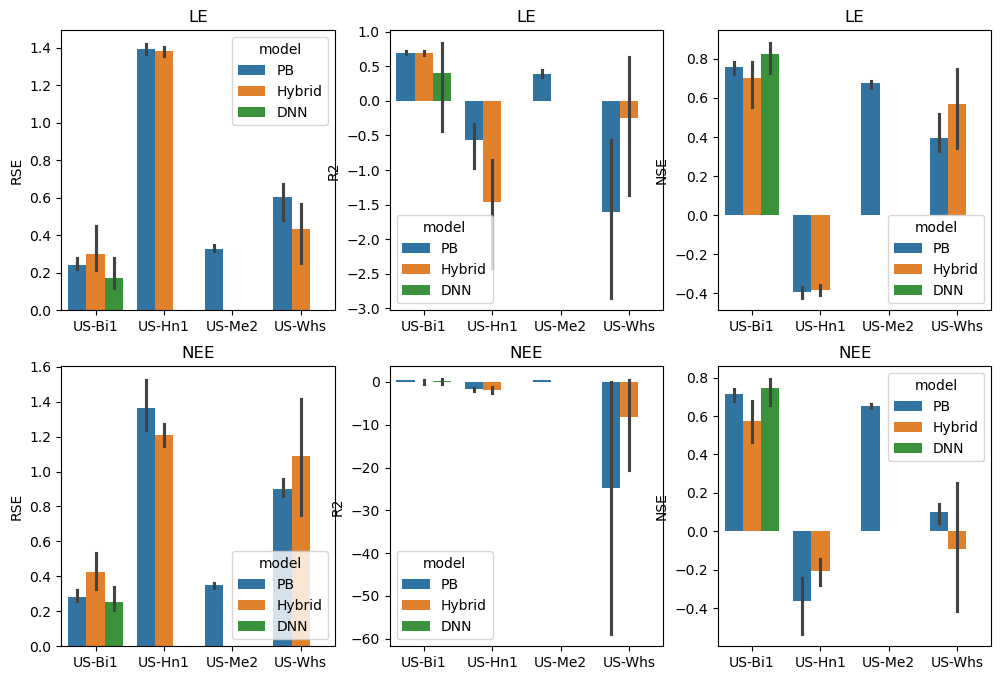

In [54]:
train_or_test, layer = "test", ["1L", "DNN"]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, varn in enumerate(["LE", "NEE"]):
    for j, metric in enumerate(["rse", "r2", "nse"]):
        ax = axes[i, j]
        df_metrics_sub = filter_metric(
            df_metrics, layer=layer, varn=varn, train_or_test=train_or_test
        )
        sns.barplot(df_metrics_sub, ax=ax, x="site", y=metric, hue="model")
        ax.set(xlabel="", ylabel=metric.upper(), title=varn)

# Multilayer canopy model vs single layer canopy model

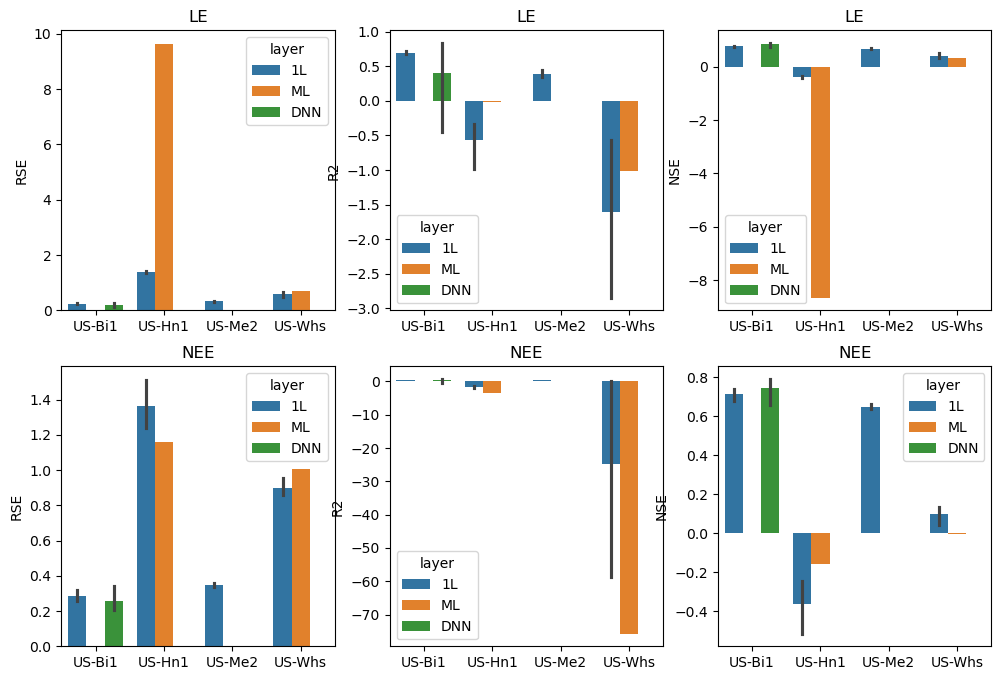

In [160]:
train_or_test, model = "test", ["PB", "DNN"]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, varn in enumerate(["LE", "NEE"]):
    for j, metric in enumerate(["rse", "r2", "nse"]):
        ax = axes[i, j]
        df_metrics_sub = filter_metric(
            df_metrics, model=model, varn=varn, train_or_test=train_or_test
        )
        sns.barplot(df_metrics_sub, ax=ax, x="site", y=metric, hue="layer")
        ax.set(xlabel="", ylabel=metric.upper(), title=varn)

# Pareto Front curve (multi-objective optimization)

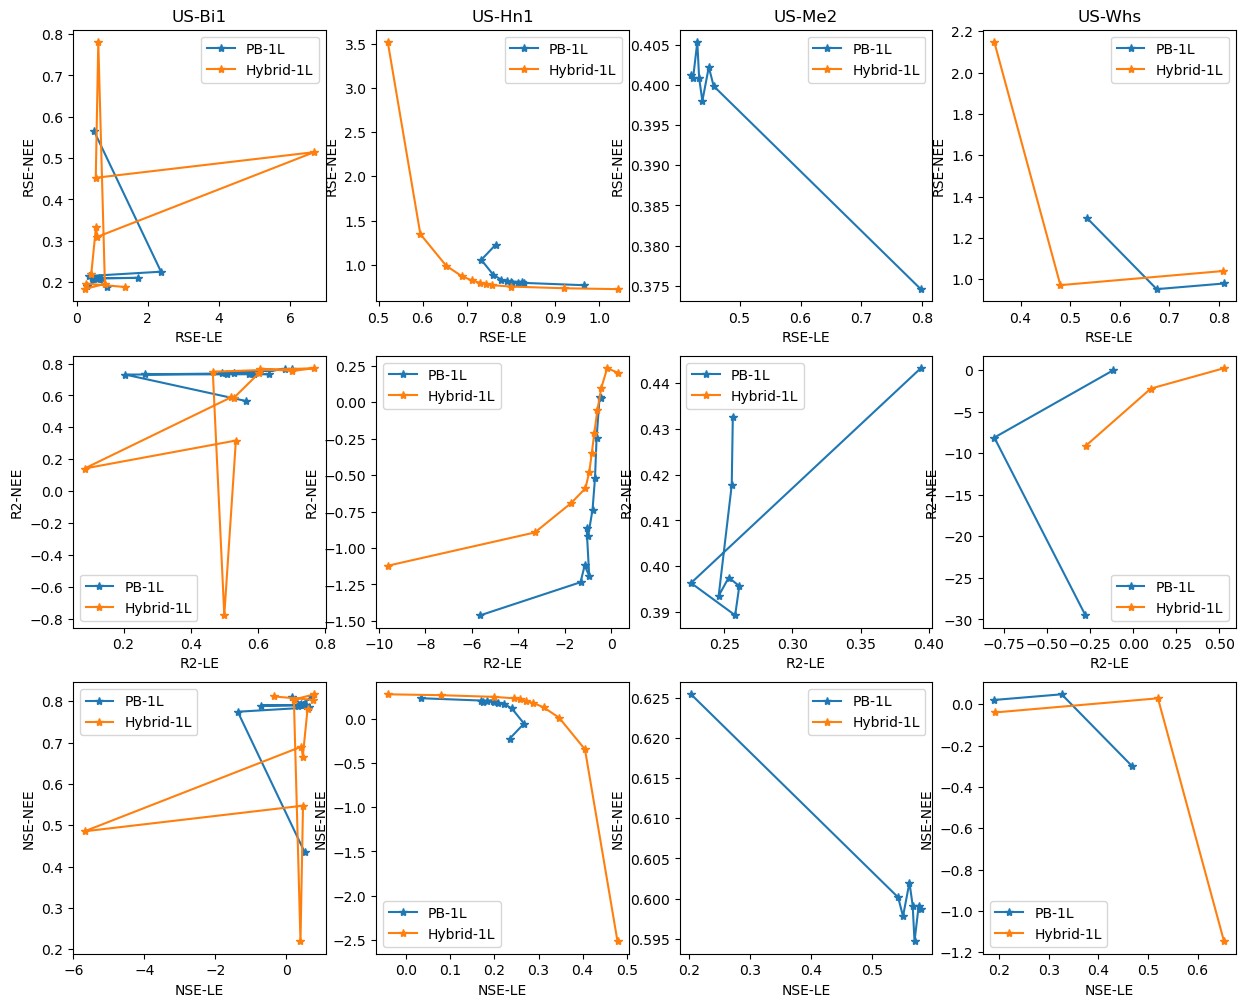

In [158]:
train_or_test, layer = "train", "1L"
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
for j, site in enumerate(sites):
    for i, metric in enumerate(["rse", "r2", "nse"]):
        ax = axes[i, j]
        # Process-based
        le_m = filter_metric(
            df_metrics,
            site=site,
            varn="LE",
            model="PB",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        nee_m = filter_metric(
            df_metrics,
            site=site,
            varn="NEE",
            model="PB",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        # ax.scatter(le_m, nee_m, label='PB-1L')
        ax.plot(le_m, nee_m, "*-", label="PB-1L")

        # Hybrid
        le_m = filter_metric(
            df_metrics,
            site=site,
            varn="LE",
            model="Hybrid",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        nee_m = filter_metric(
            df_metrics,
            site=site,
            varn="NEE",
            model="Hybrid",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        # ax.scatter(le_m, nee_m, label='Hybrid-1L')
        ax.plot(le_m, nee_m, "*-", label="Hybrid-1L")

        # DNN
        le_m = filter_metric(
            df_metrics,
            site=site,
            varn="LE",
            model="DNN",
            layer="DNN",
            train_or_test=train_or_test,
        )[metric]
        nee_m = filter_metric(
            df_metrics,
            site=site,
            varn="NEE",
            model="DNN",
            layer="DNN",
            train_or_test=train_or_test,
        )[metric]
        # ax.scatter(le_m, nee_m, label='DNN')
        ax.legend()

        ax.set(
            xlabel=f"{metric.upper()}-LE",
            ylabel=f"{metric.upper()}-NEE",
            title=site if i == 0 else "",
        )

# Time series plot

## Diurnal signal

In [97]:
def convert_to_24hr(df):
    df = df.resample("30T").mean()
    df["Time_of_Day"] = df.index.time
    # Pivot to get the average value for each 30-minute interval across 24-hour periods
    return df.groupby("Time_of_Day").mean()

/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_42641/3797816567.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.resample('30T').mean()
/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_42641/3797816567.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.resample('30T').mean()
/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_42641/3797816567.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.resample('30T').mean()
/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_42641/3797816567.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.resample('30T').mean()
/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_42641/3797816567.py:2: FutureWarning: 'T' is deprecated and will be removed in a 

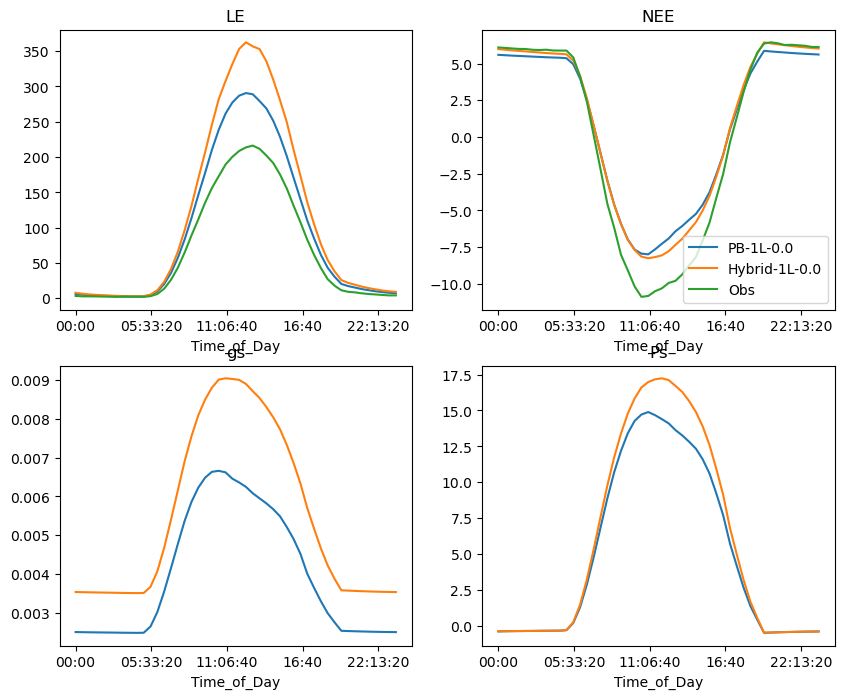

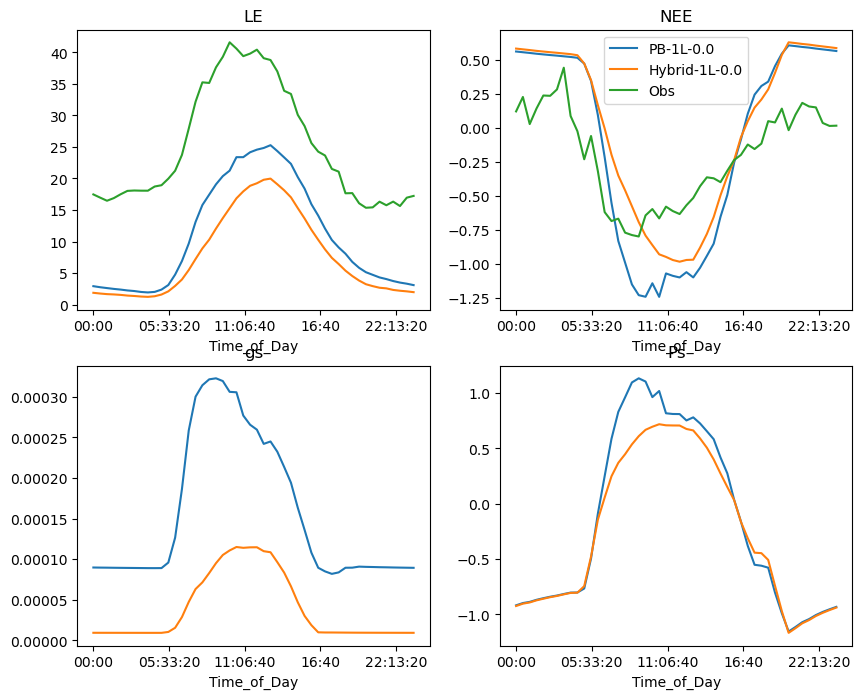

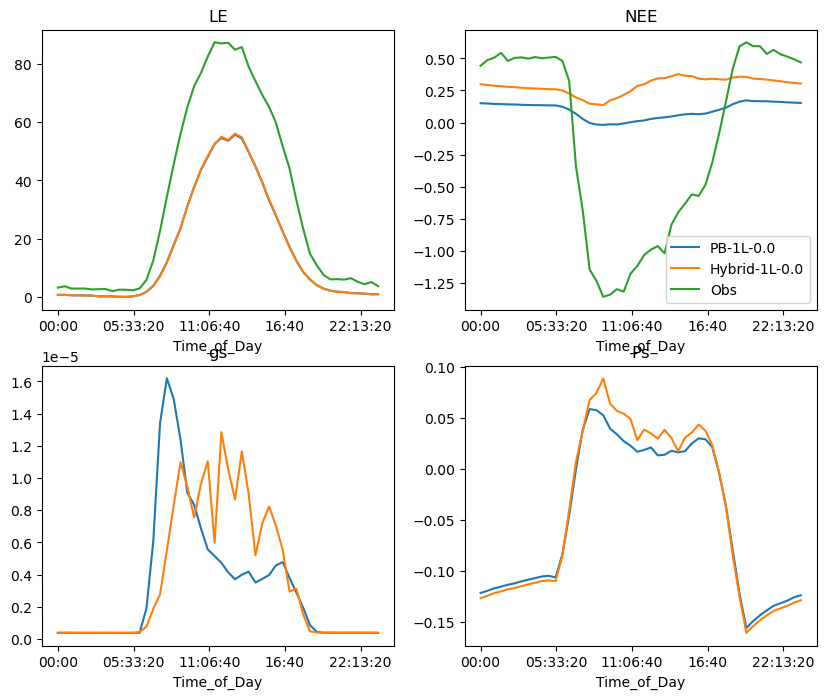

In [130]:
train_or_test, layer, weight = "test", "1L", "0.0"
# for site in sites:
for site in ["US-Bi1", "US-Hn1", "US-Whs"]:
    df = df_simulations_set[f"{site}-{train_or_test}"]
    pb = convert_to_24hr(df[f"PB-{layer}-{weight}"])
    hybrid = convert_to_24hr(df[f"Hybrid-{layer}-{weight}"])
    # dnn = convert_to_24hr(df[f'DNN_LE-GPP-{weight}'])

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()
    ax = axes[0]
    pb["LE"].plot(ax=ax, label=f"PB-{layer}-{weight}")
    hybrid["LE"].plot(ax=ax, label=f"Hybrid-{layer}-{weight}")
    pb["LE-obs"].plot(ax=ax, label="Obs")
    ax.set(title="LE")

    ax = axes[1]
    pb["NEE"].plot(ax=ax, label=f"PB-{layer}-{weight}")
    hybrid["NEE"].plot(ax=ax, label=f"Hybrid-{layer}-{weight}")
    pb["NEE-obs"].plot(ax=ax, label="Obs")
    ax.set(title="NEE")
    ax.legend()

    ax = axes[2]
    pb["gs"].plot(ax=ax, label=f"PB-{layer}-{weight}")
    hybrid["gs"].plot(ax=ax, label=f"Hybrid-{layer}-{weight}")
    ax.set(title="gs")

    ax = axes[3]
    pb["Ps"].plot(ax=ax, label=f"PB-{layer}-{weight}")
    hybrid["Ps"].plot(ax=ax, label=f"Hybrid-{layer}")
    ax.set(title="Ps")

## Full time series

In [ ]:
def convert_to_24hr(df):
    df = df.resample("30T").mean()
    df["Time_of_Day"] = df.index.time
    # Pivot to get the average value for each 30-minute interval across 24-hour periods
    return df.groupby("Time_of_Day").mean()

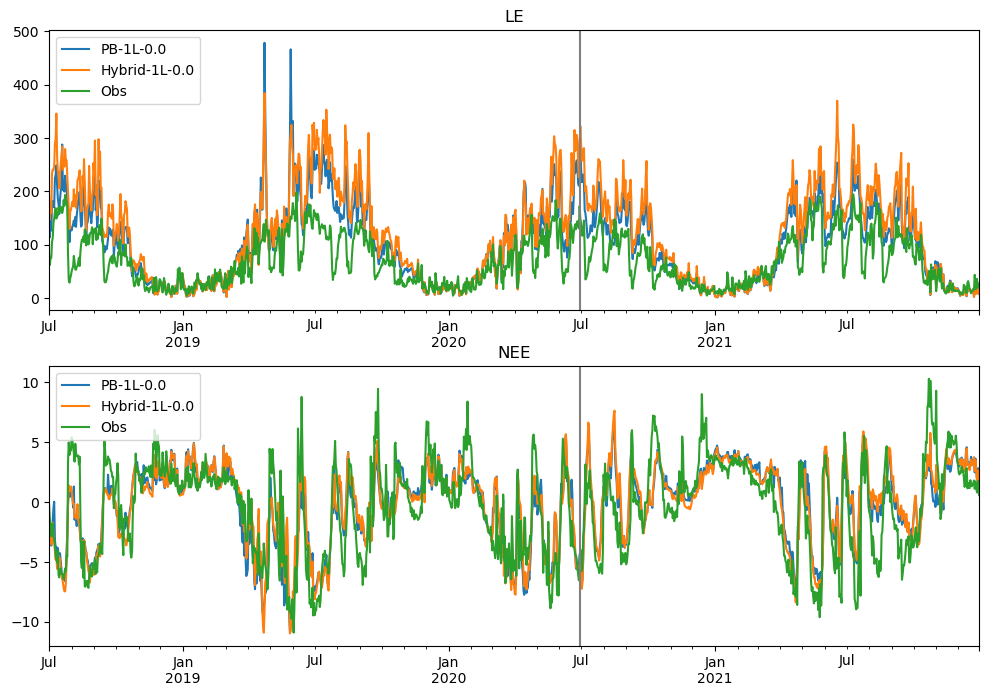

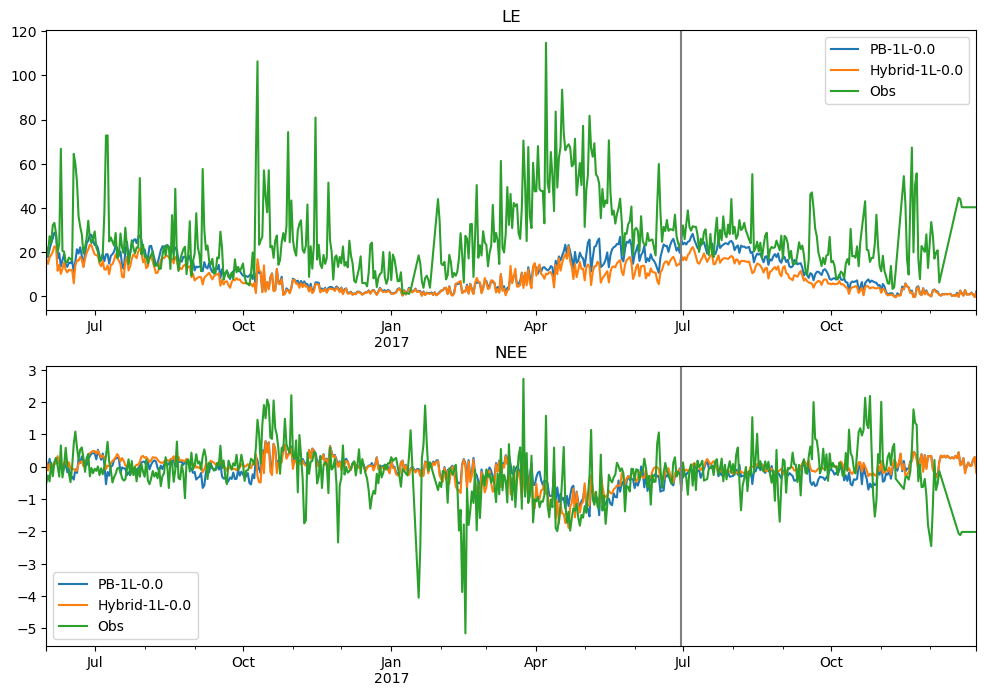

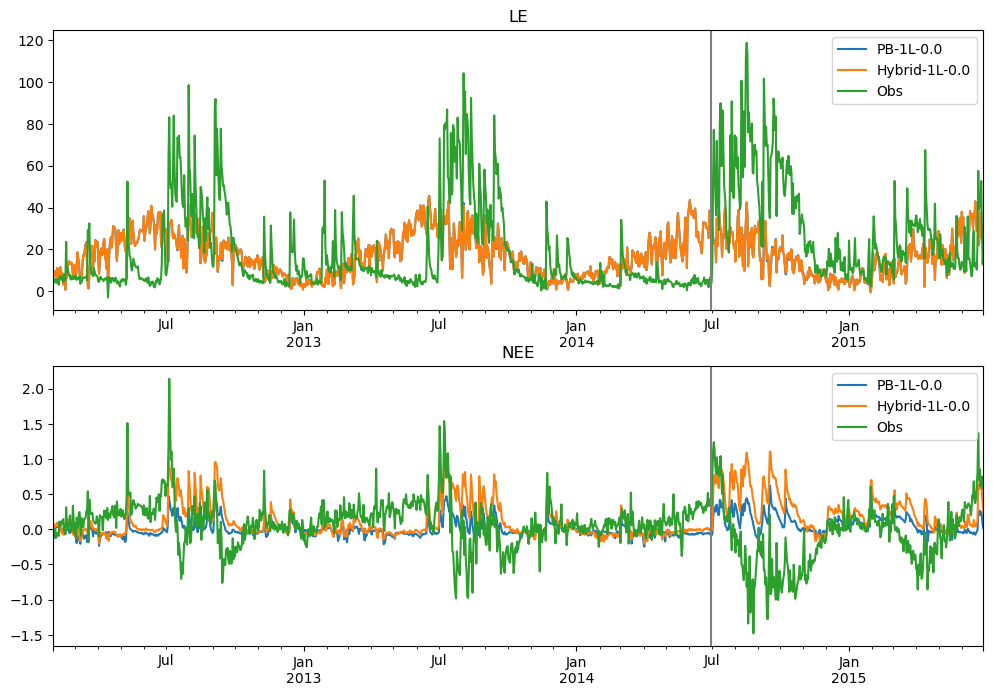

In [161]:
layer, weight = "1L", "0.0"
# for site in sites:
# for site in ['US-Bi1']:
# for site in ['US-Hn1']:
for site in ["US-Bi1", "US-Hn1", "US-Whs"]:
    # Train data
    train_pb = (
        df_simulations_set[f"{site}-train"][f"PB-{layer}-{weight}"].resample("D").mean()
    )
    train_hybrid = (
        df_simulations_set[f"{site}-train"][f"Hybrid-{layer}-{weight}"]
        .resample("D")
        .mean()
    )
    # train_dnn = df_simulations_set[f"{site}-train"][f'DNN_LE-GPP-{weight}']

    # test data
    test_pb = (
        df_simulations_set[f"{site}-test"][f"PB-{layer}-{weight}"].resample("D").mean()
    )
    test_hybrid = (
        df_simulations_set[f"{site}-test"][f"Hybrid-{layer}-{weight}"]
        .resample("D")
        .mean()
    )
    # test_dnn = df_simulations_set[f"{site}-test"][f'DNN_LE-GPP-{weight}']
    train_test_split = train_hybrid.index[-1]

    pb = pd.concat([train_pb, test_pb])
    hybrid = pd.concat([train_hybrid, test_hybrid])

    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    ax = axes[0]
    pb["LE"].plot(ax=ax, label=f"PB-{layer}-{weight}")
    hybrid["LE"].plot(ax=ax, label=f"Hybrid-{layer}-{weight}")
    pb["LE-obs"].plot(ax=ax, label="Obs")
    ax.axvline(x=train_test_split, color="grey")
    ax.legend()
    ax.set(title="LE")

    ax = axes[1]
    pb["NEE"].plot(ax=ax, label=f"PB-{layer}-{weight}")
    hybrid["NEE"].plot(ax=ax, label=f"Hybrid-{layer}-{weight}")
    pb["NEE-obs"].plot(ax=ax, label="Obs")
    ax.axvline(x=train_test_split, color="grey")
    ax.legend()
    ax.set(title="NEE")
    # ax.set(title='LE')

    # ax = axes[3]
    # train_hybrid['NEE'].plot(ax=ax, label=f'Hybrid-{layer}-{weight}')
    # train_hybrid['NEE-obs'].plot(ax=ax, label='Obs')
    # ax.legend()
    # # ax.set(title='LE')

    # ax = axes[1]
    # train_hybrid['LE'].plot(ax=ax, label=f'Hybrid-{layer}-{weight}')
    # train_hybrid['LE-obs'].plot(ax=ax, label='Obs')
    # ax.legend()
    # # ax.set(title='LE')

    # ax = axes[2]
    # train_pb['NEE'].plot(ax=ax, label=f'PB-{layer}-{weight}')
    # train_pb['NEE-obs'].plot(ax=ax, label='Obs')
    # ax.legend()
    # # ax.set(title='LE')

    # ax = axes[3]
    # train_hybrid['NEE'].plot(ax=ax, label=f'Hybrid-{layer}-{weight}')
    # train_hybrid['NEE-obs'].plot(ax=ax, label='Obs')
    # ax.legend()
    # # ax.set(title='LE')